In [119]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset



ticker = yf.Ticker("AAPL")

underlying_price = ticker.history(period='1d')['Close'].iloc[-1]

expiration_dates = ticker.options

S_data = []
t_data = []
V_data = []
K_data = []
# T_data = []
IV_data = []

# Loop over expiration dates to gather data
for expiry in expiration_dates:
    options_chain = ticker.option_chain(expiry)
    calls = options_chain.calls

    for idx, row in calls.iterrows():

        if (pd.isna(underlying_price) or pd.isna(row['bid']) or pd.isna(row['ask']) or pd.isna(row['lastPrice']) or
            pd.isna(row['strike']) or pd.isna(row['impliedVolatility']) or pd.isna((pd.to_datetime(expiry) - pd.to_datetime('today')).days / 365.0) ):
            continue  # Skip to the next row

        if row['bid'] == 0 or row['ask'] == 0:
            continue  # Skip to the next row

        S_data.append(underlying_price)  # Replace with the correct stock price if needed
        t_data.append((pd.to_datetime(expiry) - pd.to_datetime('today')).days / 365.0)  # Time to expiration in years
        # V_data.append((row['bid'] - row["ask"])/2)  # midpoint
        V_data.append((row['lastPrice'])/2)  # midpoint
        K_data.append(row['strike'])  # Strike price
        # T_data.append(expiry)
        IV_data.append(row['impliedVolatility'])  # Implied volatilities

# Convert lists to tensors for model training
S_tensor = torch.tensor(S_data, dtype=torch.float32).unsqueeze(1)
t_tensor = torch.tensor(t_data, dtype=torch.float32).unsqueeze(1)
V_tensor = torch.tensor(V_data, dtype=torch.float32).unsqueeze(1)
K_tensor = torch.tensor(K_data, dtype=torch.float32).unsqueeze(1)
IV_tensor = torch.tensor(IV_data, dtype=torch.float32).unsqueeze(1)
# T_tensor = torch.tensor(T_data, dtype=torch.float32).unsqueeze(1)


total_size = len(S_tensor)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # Ensures the rest goes to the test set

S_train, S_val, S_test = S_tensor[:train_size], S_tensor[train_size:train_size + val_size], S_tensor[train_size + val_size:]
t_train, t_val, t_test = t_tensor[:train_size], t_tensor[train_size:train_size + val_size], t_tensor[train_size + val_size:]
V_train, V_val, V_test = V_tensor[:train_size], V_tensor[train_size:train_size + val_size], V_tensor[train_size + val_size:]
K_train, K_val, K_test = K_tensor[:train_size], K_tensor[train_size:train_size + val_size], K_tensor[train_size + val_size:]
IV_train, IV_val, IV_test = IV_tensor[:train_size], IV_tensor[train_size:train_size + val_size], IV_tensor[train_size + val_size:]



In [120]:
print(V_train)

tensor([[1.1001e+02],
        [1.0915e+02],
        [8.2325e+01],
        [7.3650e+01],
        [6.5190e+01],
        [6.2695e+01],
        [6.5055e+01],
        [6.2495e+01],
        [5.4570e+01],
        [5.7515e+01],
        [5.3225e+01],
        [4.6670e+01],
        [4.8225e+01],
        [4.7300e+01],
        [4.3235e+01],
        [4.2535e+01],
        [3.6195e+01],
        [3.5740e+01],
        [3.3250e+01],
        [3.2375e+01],
        [2.9900e+01],
        [2.7175e+01],
        [2.4750e+01],
        [2.2400e+01],
        [1.9725e+01],
        [1.5105e+01],
        [1.7510e+01],
        [1.5000e+01],
        [1.3360e+01],
        [1.2325e+01],
        [1.0915e+01],
        [1.0200e+01],
        [8.2000e+00],
        [7.7000e+00],
        [6.0250e+00],
        [5.0000e+00],
        [3.8350e+00],
        [2.6750e+00],
        [1.4750e+00],
        [3.7500e-01],
        [2.0000e-02],
        [5.6875e+01],
        [5.8545e+01],
        [5.5075e+01],
        [4.9235e+01],
        [5

In [121]:
!git clone https://github.com/Blealtan/efficient-kan.git
!cd efficient-kan && pip install .

fatal: destination path 'efficient-kan' already exists and is not an empty directory.
Processing /content/efficient-kan
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for efficient-kan: filename=efficient_kan-0.1.0-py3-none-any.whl size=5732 sha256=3ef1a2ecc035552022ca1dbb071a4d2df50f59173e279c345e9b8afd624d4270
  Stored in directory: /root/.cache/pip/wheels/03/9e/5e/a67dcdc4f819da270f0f599858798db09ad810c415559d3aea
Successfully built efficient-kan
  Attempting uninstall: efficient-kan
    Found existing installation: efficient-kan 0.1.0
    Uninstalling efficient-kan-0.1.0:
      Successfully uninstalled efficient-kan-0.1.0


In [122]:
!cd efficient-kan
from efficient_kan import KAN, KANLinear

In [123]:
# T is expiration data
# t is current time to expiration
# we call tau current time, where tau = T - t

def black_scholes_pde_loss(model, V_target, S, t, K, r, sigma, option_type="call"):
    # Concat S and t
    r = torch.full_like(S, r)
    inputs = torch.cat((S, t), dim=1)
    inputs_at_T = torch.cat((S, torch.zeros_like(t)), dim=1)
    inputs_at_zero_underlying = torch.cat((torch.zeros_like(S), t), dim=1)
    S_large = 100000*K
    inputs_at_inf_underlying = torch.cat((S_large, t), dim=1)

    V = model(inputs)
    V_at_T = model(inputs_at_T)
    V_at_zero_underlying = model(inputs_at_zero_underlying)
    V_at_inf_underlying = model(inputs_at_inf_underlying)

    # Compute derivatives using autograd
    V_t = autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_S = autograd.grad(V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_SS = autograd.grad(V_S, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # Black-Scholes PDE loss
    pde_loss = torch.mean((V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V)**2)

    # if option_type == "call":
    #     bc1 = torch.maximum(S - K, torch.zeros_like(S))  # Final condition at t=T for call option
    #     bc2 = torch.zeros_like(t)
    #     bc3 = S_large - K * torch.exp(-r * (t))


    # else:
    #     bc1 = torch.maximum(K - S, torch.zeros_like(S))  # For put option
    #     bc2 = K * torch.exp(-r * (t))
    #     bc3 = torch.zeros_like(t)


    # bc_loss = torch.mean((V_at_T - bc1)**2) + torch.mean((V_at_zero_underlying - bc2)**2) + torch.mean((V_at_inf_underlying - bc3)**2)
    bc_loss = 0

    data_loss = torch.mean((V - V_target)**2)

    return (pde_loss + bc_loss + data_loss), pde_loss, bc_loss, data_loss, V



In [124]:
num_epochs = 100
learning_rate = 1e-3

# model = nn.Sequential(nn.Linear(2, 64), nn.ReLU(), nn.Linear(64,64), nn.ReLU(), nn.Linear(64, 1), nn.ReLU())
model = KAN([2,64,64,1])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# S_train, t_train, V_train, K_train, IV_train tensors

# Create a TensorDataset and DataLoader for batching
train_dataset = TensorDataset(S_train, t_train, V_train, K_train, IV_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed

val_dataset = TensorDataset(S_val, t_val, V_val, K_val, IV_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed

r = 4.519/100 # 1 year treasury bill

train_losses = []
val_losses = []

train_mse_losses = []
val_mse_losses = []

train_pde_losses = []
val_pde_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_mse_loss = 0
    train_pde_loss = 0

    for batch in train_loader:
        S_batch, t_batch, V_target_batch, K_batch, IV_batch = batch

        # Extract S and t from inputs
        # S_batch = inputs_batch[:, 0].unsqueeze(1)
        # t_batch = inputs_batch[:, 1].unsqueeze(1)
        S_batch.requires_grad_(True)
        t_batch.requires_grad_(True)

        optimizer.zero_grad()

        # Compute the loss using the fixed risk-free rate
        loss, pde_loss, bc_loss, mse_loss, pred = black_scholes_pde_loss(model, V_target_batch, S_batch, t_batch, K_batch, r, IV_batch)
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        train_pde_loss += pde_loss.item()
        train_mse_loss += mse_loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_pde_loss /= len(train_loader)
    train_pde_losses.append(train_pde_loss)
    train_mse_loss /= len(train_loader)
    train_mse_losses.append(train_mse_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_mse_loss = 0.0
    val_pde_loss = 0.0

    for batch in val_loader:
        S_batch, t_batch, V_target_batch, K_batch, IV_batch = batch
        S_batch.requires_grad_(True)
        t_batch.requires_grad_(True)

        optimizer.zero_grad()

        # Compute the loss using the fixed risk-free rate
        loss, pde_loss, bc_loss, mse_loss, pred = black_scholes_pde_loss(model, V_target_batch, S_batch, t_batch, K_batch, r, IV_batch)
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        val_loss += loss.item()
        val_pde_loss += pde_loss.item()
        val_mse_loss += mse_loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_pde_loss /= len(val_loader)
    val_pde_losses.append(val_pde_loss)
    val_mse_loss /= len(val_loader)
    val_mse_losses.append(val_mse_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')


Epoch 1/100, Training Loss: 818.182010, Validation Loss: 930.587231
Epoch 2/100, Training Loss: 842.495187, Validation Loss: 841.393286
Epoch 3/100, Training Loss: 866.184256, Validation Loss: 972.064575
Epoch 4/100, Training Loss: 834.426978, Validation Loss: 934.522223
Epoch 5/100, Training Loss: 853.909805, Validation Loss: 978.747864
Epoch 6/100, Training Loss: 840.584970, Validation Loss: 995.563562
Epoch 7/100, Training Loss: 816.316354, Validation Loss: 944.579407
Epoch 8/100, Training Loss: 838.272852, Validation Loss: 1258.062036
Epoch 9/100, Training Loss: 838.224762, Validation Loss: 1081.727283
Epoch 10/100, Training Loss: 810.628510, Validation Loss: 1028.474255
Epoch 11/100, Training Loss: 803.245270, Validation Loss: 972.621179
Epoch 12/100, Training Loss: 796.662469, Validation Loss: 958.616174
Epoch 13/100, Training Loss: 820.009692, Validation Loss: 1108.723926
Epoch 14/100, Training Loss: 816.055397, Validation Loss: 1064.627051
Epoch 15/100, Training Loss: 796.50847

In [125]:
test_dataset = torch.utils.data.TensorDataset(S_test, t_test, V_test, K_test, IV_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Initialize the total loss
test_loss = 0.0

predictions = []

for batch in test_loader:
    S_batch, t_batch, V_target_batch, K_batch, IV_batch = batch

    S_batch.requires_grad_(True)
    t_batch.requires_grad_(True)

    # Compute the loss using the fixed risk-free rate
    loss, pde_loss, bc_loss, mse_loss, pred = black_scholes_pde_loss(model, V_target_batch, S_batch, t_batch, K_batch, r, IV_batch)
    predictions.extend(pred.squeeze().tolist())
    test_loss += loss.item()

# Calculate the average loss
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {test_loss:.6f}')

Average Test Loss: 3506.186371


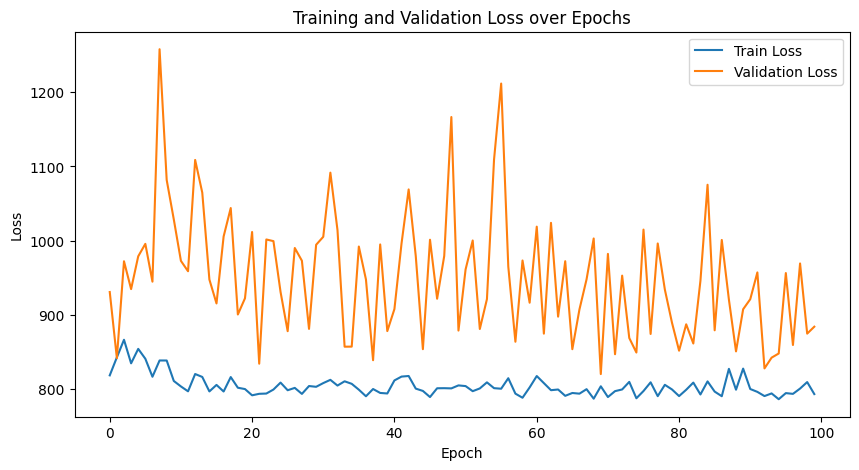

In [126]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

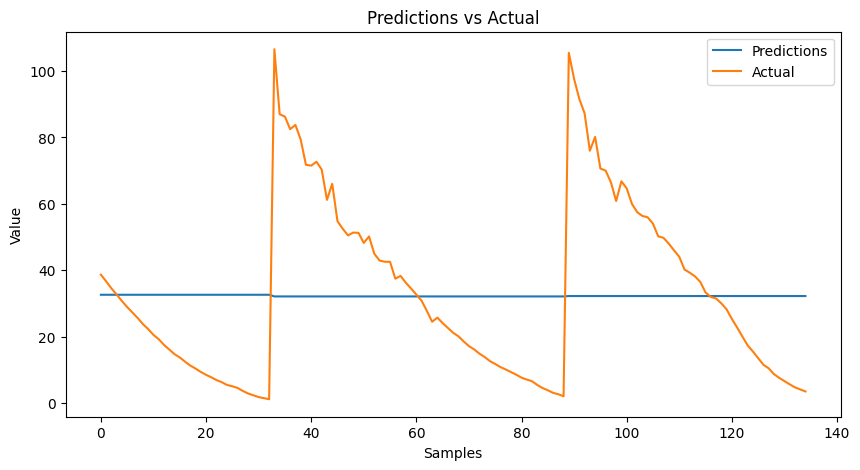

In [127]:
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions')
plt.plot(V_test, label='Actual')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()